# AIR project - Investigating effects of bias and toxicity in sentiment analysis
**NOTE:** This notebook takes a lot of time to run to completion. To minimize this, please run the project on a GPU or reduce the number of processed tweets.

## Initial Setup

This notebook was developed on Google Colab. As such, we begin by installing and importing the required libraries/modules to run this project.

In [1]:
!pip install transformers
!pip install datasets 
!pip install evaluate
!pip install sentencepiece
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wh

In [2]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoModelWithLMHead
from transformers import pipeline
from datasets import load_dataset, DatasetDict
from wordcloud import WordCloud
import evaluate
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random

We proceed by loading the required dataset from Hugging Face. We chose TSATC: "Twitter Sentiment Analysis Training Corpus", a dataset trained for the task of sentiment analysis, consisting of tweets and a respective label regarding sentiment (0 for negative, 1 for positive). The dataset is already split into train, test, and validation sets.

More information on this dataset can be found at http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/

In [3]:
# Loading dataset from huggingface
train = load_dataset("carblacac/twitter-sentiment-analysis", "train", split="train")
test = load_dataset("carblacac/twitter-sentiment-analysis", "test", split="test")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-0eab58ac1f79f265/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/149985 [00:00<?, ?ex/s]

  0%|          | 0/61998 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/120 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/30 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/62 [00:00<?, ?ba/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset twitter-sentiment-analysis downloaded and prepared to /root/.cache/huggingface/datasets/carblacac___twitter-sentiment-analysis/train/1.0.0/cd65e23e456de6a4f7264e305380b0ffe804d6f5bfd361c0ec0f68d8d1fab95b. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Creating json from Arrow format:   0%|          | 0/120 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/30 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/62 [00:00<?, ?ba/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset twitter-sentiment-analysis downloaded and prepared to /root/.cache/huggingface/datasets/carblacac___twitter-sentiment-analysis/test/1.0.0/cd65e23e456de6a4f7264e305380b0ffe804d6f5bfd361c0ec0f68d8d1fab95b. Subsequent calls will reuse this data.


## Data Structure

Each data example consists of a tweet (labeled "text") and the respective associated sentiment (labeled "feeling"). Here, we print a few examples from the train split of the dataset.

In [4]:
# Get data examples
print(len(train))
print(train[0:3])
print(train[1])
print(train[2])

for i in range(len(train)):
  print(train[i])
  if i == 5:
    break

119988
{'text': ['@fa6ami86 so happy that salman won.  btw the 14sec clip is truely a teaser', "@phantompoptart .......oops.... I guess I'm kinda out of it.... Blonde moment -blushes- epic fail", "@bradleyjp decidedly undecided. Depends on the situation. When I'm out with the people I'll be in Chicago with? Maybe."], 'feeling': [0, 0, 1]}
{'text': "@phantompoptart .......oops.... I guess I'm kinda out of it.... Blonde moment -blushes- epic fail", 'feeling': 0}
{'text': "@bradleyjp decidedly undecided. Depends on the situation. When I'm out with the people I'll be in Chicago with? Maybe.", 'feeling': 1}
{'text': '@fa6ami86 so happy that salman won.  btw the 14sec clip is truely a teaser', 'feeling': 0}
{'text': "@phantompoptart .......oops.... I guess I'm kinda out of it.... Blonde moment -blushes- epic fail", 'feeling': 0}
{'text': "@bradleyjp decidedly undecided. Depends on the situation. When I'm out with the people I'll be in Chicago with? Maybe.", 'feeling': 1}
{'text': '@Mountgrac

We split the training dataset into tweets classified as positive and tweets classified as negative. This will allow us to compare metrics for both splits.

In [5]:
negative_tweets = []
positive_tweets = []

# Number of positive and negative tweets to use
n_tweets = 250

for tweet in train:
  if len(negative_tweets) == n_tweets and len(positive_tweets) == n_tweets:
    break
  if len(negative_tweets) < n_tweets and tweet["feeling"] == 0:
    negative_tweets.append(tweet["text"])
  elif len(positive_tweets) < n_tweets and tweet["feeling"] == 1:
   positive_tweets.append(tweet["text"])

print(len(positive_tweets))

250


In [6]:
print("Number of positive tweets: ", len(positive_tweets))
print("Number of negative tweets: ", len(negative_tweets))

Number of positive tweets:  250
Number of negative tweets:  250


## Bias Detection Model Setup

We import a model that performs bias detection on text.

In [7]:
# Bias score model
tokenizer = AutoTokenizer.from_pretrained("d4data/bias-detection-model")
# Huggingface model
model = TFAutoModelForSequenceClassification.from_pretrained("d4data/bias-detection-model")

classifier = pipeline('text-classification', model=model, tokenizer=tokenizer) # cuda = 0,1 based on gpu availability
#classifier("The irony, of course, is that the exhibit that invites people to throw trash at vacuuming Ivanka Trump lookalike reflects every stereotype feminists claim to stand against, oversexualizing Ivanka’s body and ignoring her hard work.")

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at d4data/bias-detection-model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


## Toxicity Model Setup

We use evaluate to measure the toxicity of tweets. The model used is the default for evaluate, [roberta-hate-speech-dynabench-r4](https://huggingface.co/facebook/roberta-hate-speech-dynabench-r4-target).

In [8]:
# Toxicity from evaluate
toxicity = evaluate.load("toxicity")

Downloading:   0%|          | 0.00/816 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

## Preprocessing Data

We create a version of the data that includes stopword removal, punctuation stripping, and stemming.

In [9]:
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, stem_text

pos_tweets_processed = []
neg_tweets_processed = []
for tweet in positive_tweets:
    pos_tweets_processed.append(stem_text(strip_punctuation(remove_stopwords(tweet))))
for tweet in negative_tweets:
    neg_tweets_processed.append(stem_text(strip_punctuation(remove_stopwords(tweet))))


## Bias/Toxicity Evaluation

We collect the scores for bias and toxicity values, for both the original data and the preprocessed data.

In [10]:
def bias_score(tweet_list):
  scores = list(map(lambda tweet: 
                    classifier(tweet)[0]["score"], tweet_list))
  return scores

# no processing
pos_bias_scores = bias_score(positive_tweets)
neg_bias_scores = bias_score(negative_tweets)
print(pos_bias_scores)
print(neg_bias_scores)

# with processing
pos_p_bias_scores = bias_score(pos_tweets_processed)
neg_p_bias_scores = bias_score(neg_tweets_processed)
print(pos_p_bias_scores)
print(neg_p_bias_scores)

[0.6439589858055115, 0.6027644872665405, 0.7503039836883545, 0.7187623977661133, 0.8388451933860779, 0.9834670424461365, 0.505879282951355, 0.5028093457221985, 0.6665201783180237, 0.5497741103172302, 0.7112293839454651, 0.7836087942123413, 0.6550307869911194, 0.5833346247673035, 0.601118803024292, 0.8847100138664246, 0.6406186819076538, 0.6419448852539062, 0.6687443852424622, 0.9921395182609558, 0.5598680377006531, 0.7648443579673767, 0.7355785369873047, 0.8532266616821289, 0.6339993476867676, 0.6336830854415894, 0.9749767184257507, 0.9869994521141052, 0.6627382040023804, 0.5776882767677307, 0.5902543067932129, 0.8221911191940308, 0.5165534019470215, 0.6947305798530579, 0.528661847114563, 0.6288332343101501, 0.9849604964256287, 0.9767664670944214, 0.6126731038093567, 0.7517842054367065, 0.9825229644775391, 0.8451440930366516, 0.7155665159225464, 0.9953508377075195, 0.9953263998031616, 0.6622289419174194, 0.5738276839256287, 0.9900549650192261, 0.7255102396011353, 0.7096927165985107, 0.

In [11]:
# no processing
pos_results = toxicity.compute(predictions=positive_tweets)
pos_toxicity_scores = pos_results["toxicity"]
print(pos_toxicity_scores)

neg_results = toxicity.compute(predictions=negative_tweets)
neg_toxicity_scores = neg_results["toxicity"]
print(neg_toxicity_scores)

# with processing
pos_p_results = toxicity.compute(predictions=pos_tweets_processed)
pos_p_toxicity_scores = pos_p_results["toxicity"]
print(pos_p_toxicity_scores)

neg_p_results = toxicity.compute(predictions=neg_tweets_processed)
neg_p_toxicity_scores = neg_p_results["toxicity"]
print(neg_p_toxicity_scores)

[0.007888207212090492, 0.0008036588551476598, 0.0005687674856744707, 0.007348984479904175, 0.001940663903951645, 0.00021965325868222862, 0.00013883654901292175, 0.0006964914500713348, 0.029954340308904648, 0.0001719554275041446, 0.0037294216454029083, 0.0017170077189803123, 0.0001503917737863958, 0.0028289775364100933, 0.00015599677863065153, 0.0008235509158112109, 0.022506196051836014, 0.01922590099275112, 0.0004395457508508116, 0.0004935819306410849, 0.0016112199518829584, 0.00013980902440380305, 0.0018147157970815897, 0.00019689512555487454, 0.999169111251831, 0.005161552224308252, 0.0015058194985613227, 0.0009299677913077176, 0.9751063585281372, 0.0019218260422348976, 0.00014218976139090955, 0.1958419382572174, 0.003722087014466524, 0.0007584604318253696, 0.013923732563853264, 0.001177504425868392, 0.00015429581981152296, 0.0003632633888628334, 0.003853668225929141, 0.0007540175574831665, 0.0019879708997905254, 0.07088584452867508, 0.00016030627011787146, 0.006019842345267534, 0.00

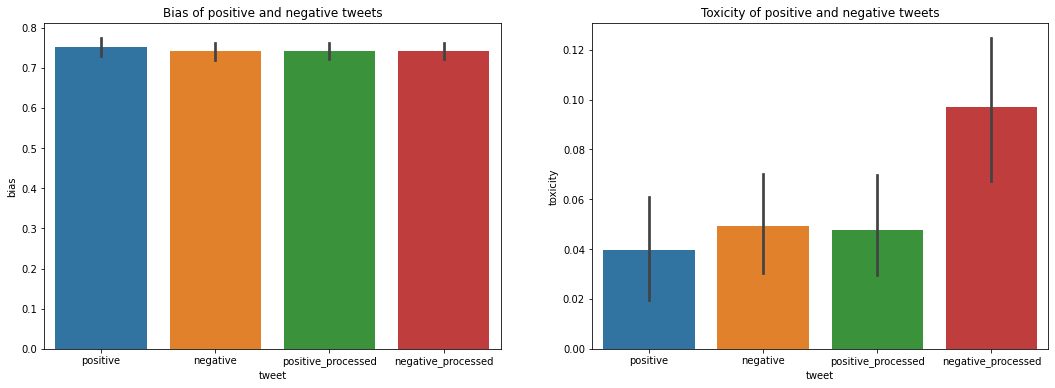

Average Positive Bias:  0.7517847201824188
Average Negative Bias:  0.7407738544940948
Average Positive Toxicity:  0.039637281907838766
Average Negative Toxicity:  0.04909560993901687


In [12]:
def plot_bias_toxicity():
    fig, axes = plt.subplots(1, 2, figsize=(18,6))
    data_bias = pd.DataFrame({"positive": pos_bias_scores,
                              "negative": neg_bias_scores,
                              "positive_processed": pos_p_bias_scores,
                              "negative_processed": neg_p_bias_scores})
    data_toxicity = pd.DataFrame({"positive": pos_toxicity_scores,
                                  "negative": neg_toxicity_scores,
                                  "positive_processed": pos_p_toxicity_scores,
                                  "negative_processed": neg_p_toxicity_scores})
    sns.barplot(ax=axes[0], data=data_bias).set(xlabel="tweet", ylabel="bias", title="Bias of positive and negative tweets")
    sns.barplot(ax=axes[1], data=data_toxicity).set(xlabel="tweet", ylabel="toxicity", title="Toxicity of positive and negative tweets")
    plt.show()

plot_bias_toxicity()
print("Average Positive Bias: ", sum(pos_bias_scores)/len(pos_bias_scores))
print("Average Negative Bias: ", sum(neg_bias_scores)/len(neg_bias_scores))

print("Average Positive Toxicity: ", sum(pos_toxicity_scores)/len(pos_toxicity_scores))
print("Average Negative Toxicity: ", sum(neg_toxicity_scores)/len(neg_toxicity_scores))

## Emotion Recognition Model Setup

We use a fine-tuned T5 model for detecting sadness, joy, love, anger, fear and surprise in the tweets.

In [13]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/auto/modeling_auto.py:1177: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [14]:
def get_emotion(text):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

  output = model.generate(input_ids=input_ids,
               max_length=2)
  
  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]
  return label.split()[1]

We collect data regarding the emotion attributed to each tweet.

In [15]:

# no processing
emotions = []
all_emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]
pos_emotion_dict = {"sadness": 0, "joy": 0, "love": 0, "anger": 0, "fear": 0, "surprise": 0}
neg_emotion_dict = {"sadness": 0, "joy": 0, "love": 0, "anger": 0, "fear": 0, "surprise": 0}

for tweet in positive_tweets:
  emotion = get_emotion(tweet)
  if emotion in all_emotions:
    emotions.append(emotion)
    pos_emotion_dict[emotion] += 1
  else:
    emotions.append("unknown")


for tweet in negative_tweets:
  emotion = get_emotion(tweet)
  if emotion in all_emotions:
    emotions.append(emotion)
    neg_emotion_dict[emotion] += 1
  else:
    emotions.append("unknown")
  

# with processing
emotions_p = []
pos_p_emotion_dict = {"sadness": 0, "joy": 0, "love": 0, "anger": 0, "fear": 0, "surprise": 0}
neg_p_emotion_dict = {"sadness": 0, "joy": 0, "love": 0, "anger": 0, "fear": 0, "surprise": 0}

for tweet in pos_tweets_processed:
  emotion = get_emotion(tweet)
  if emotion in all_emotions:
    emotions_p.append(emotion)
    pos_p_emotion_dict[emotion] += 1
  else:
    emotions_p.append("unknown")

for tweet in neg_tweets_processed:
  emotion = get_emotion(tweet)
  if emotion in all_emotions:
    emotions_p.append(emotion)
    neg_p_emotion_dict[emotion] += 1
  else:
    emotions_p.append("unknown")

In [16]:
print(pos_emotion_dict)
print(neg_emotion_dict)

print(pos_p_emotion_dict)
print(neg_p_emotion_dict)

{'sadness': 20, 'joy': 184, 'love': 5, 'anger': 28, 'fear': 11, 'surprise': 2}
{'sadness': 62, 'joy': 88, 'love': 3, 'anger': 74, 'fear': 22, 'surprise': 1}
{'sadness': 7, 'joy': 159, 'love': 4, 'anger': 62, 'fear': 18, 'surprise': 0}
{'sadness': 33, 'joy': 106, 'love': 3, 'anger': 82, 'fear': 26, 'surprise': 0}


## Creating a Pandas Dataframe

We setup a Pandas df containing all the information collected so far (corpus, bias values, toxicity values, and emotions for both the original data and the preprocessed)

In [17]:
sns.set(style='ticks')

In [18]:
df = pd.DataFrame(list(zip(positive_tweets + negative_tweets, pos_tweets_processed + neg_tweets_processed, [1]*n_tweets + [0]*n_tweets, pos_bias_scores + neg_bias_scores, pos_p_bias_scores + neg_p_bias_scores, pos_toxicity_scores + neg_toxicity_scores, pos_p_toxicity_scores + neg_p_toxicity_scores, emotions, emotions_p)),
               columns =['corpus', 'corpus_w_processing', 'feeling', 'bias', 'bias_w_processing', 'toxicity', 'toxicity_w_processing', 'emotion', 'emotion_w_processing'])
df = df.assign(feeling_str=df.feeling.map({0: "negative", 1: "positive"}))
df.head()

,corpus,corpus_w_processing,feeling,bias,bias_w_processing,toxicity,toxicity_w_processing,emotion,emotion_w_processing,feeling_str
0,@bradleyjp decidedly undecided. Depends on the...,bradleyjp decidedli undecid depend situat when...,1,0.643959,0.712257,0.007888,0.003964,fear,joy,positive
1,@Mountgrace lol i know! its so frustrating isn...,mountgrac lol know frustrat isnt it,1,0.602764,0.550957,0.000804,0.001337,anger,anger,positive
2,@kathystover Didn't go much of any where - Lif...,kathystov didn t life took,1,0.750304,0.694970,0.000569,0.014096,anger,anger,positive
3,@TashaWilson like questions she asks me the da...,tashawilson like question ask date etc i birmi...,1,0.718762,0.673747,0.007349,0.006119,fear,fear,positive
4,@SusanCosmos @speakgirl Thx 4 sharing!,susancosmo speakgirl thx 4 share,1,0.838845,0.797446,0.001941,0.006792,joy,joy,positive


In [19]:
# Make another dataframe for analyzing frequency of emotions
def make_freq_df():
    df_neg = df[df["feeling"] == 0]
    df_pos = df[df["feeling"] == 1]
    vc_pos_p = df_pos["emotion_w_processing"].value_counts(normalize=True)
    vc_neg_p = df_neg["emotion_w_processing"].value_counts(normalize=True)
    df_freq = pd.concat({"positive_processed": vc_pos_p, "negative_processed": vc_neg_p}, axis=1).fillna(0)
    return df_freq

df_emotion_freq = make_freq_df()
df_emotion_freq.head()

,positive_processed,negative_processed
joy,0.636,0.424
anger,0.248,0.328
fear,0.072,0.104
sadness,0.028,0.132
love,0.016,0.012


## Toxicity/Bias Plots

We plot bias and toxicity according to each type of emotion expressed in the tweets.

In [20]:
_emotions= ["sadness", "joy", "love", "anger", "fear", "surprise"]
_feelings_order = ["negative", "positive"]

### Without Preprocessing

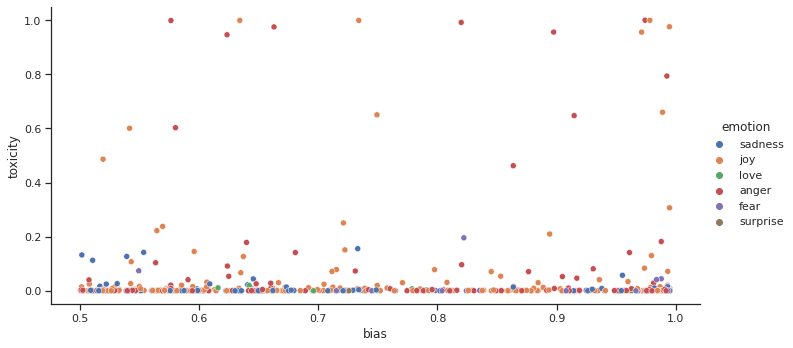

In [21]:
sns.relplot(data=df, x='bias', y='toxicity', hue='emotion', hue_order=_emotions, aspect=2)
plt.show()

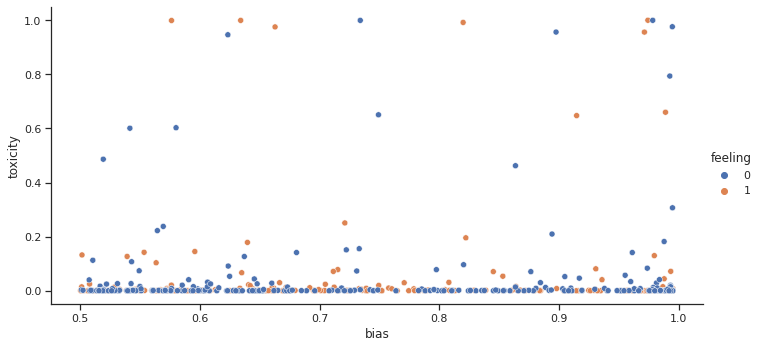

In [22]:
sns.relplot(data=df, x='bias', y='toxicity', hue='feeling', aspect=2)
plt.show()

### With Preprocessing

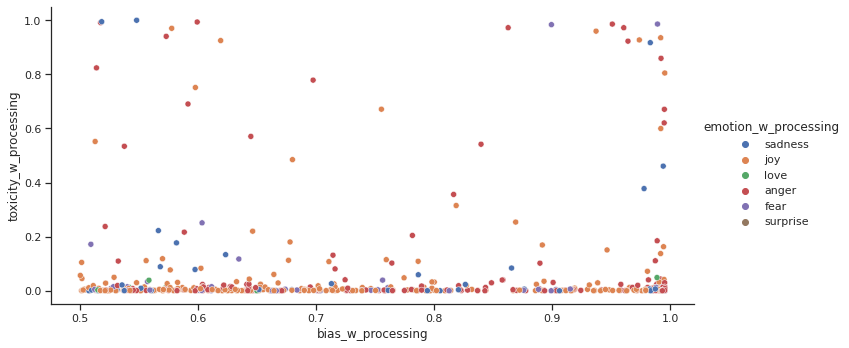

In [23]:
sns.relplot(data=df, x='bias_w_processing', y='toxicity_w_processing', hue='emotion_w_processing', hue_order=_emotions, aspect=2)
plt.show()

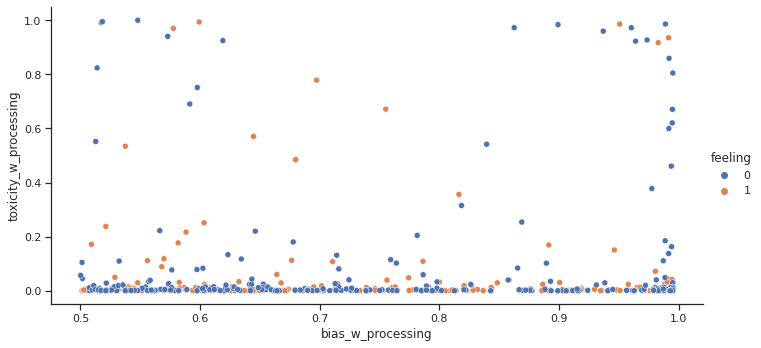

In [24]:
sns.relplot(data=df, x='bias_w_processing', y='toxicity_w_processing', hue='feeling', aspect=2)
plt.show()

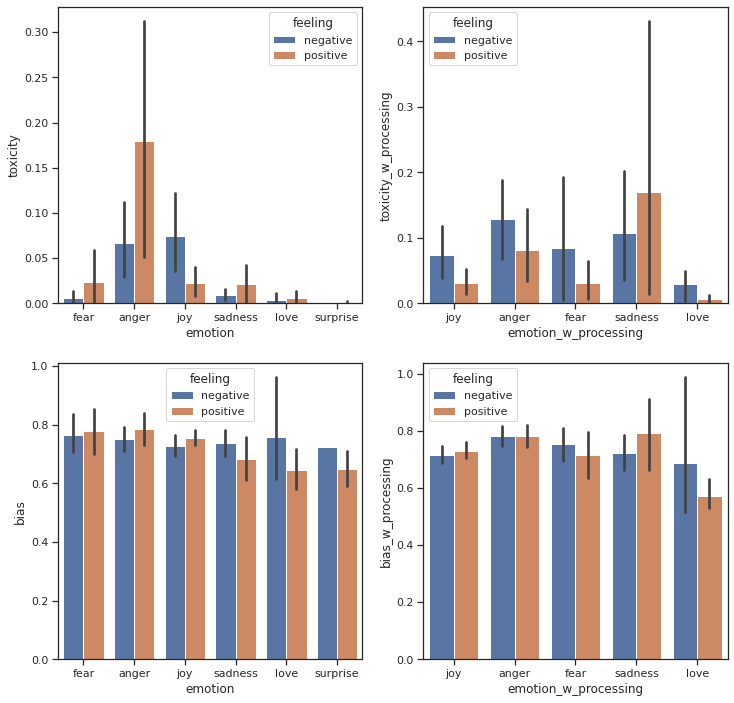

In [25]:
def plot_bias_tox_emotion():
    def plot(**kwargs):
        kwargs.setdefault("x", "emotion")
        sns.barplot(data=df, hue='feeling_str', hue_order=_feelings_order, **kwargs).get_legend().set_title("feeling")
    fig, axes = plt.subplots(2, 2, figsize=(12,12))
    plot(ax=axes[0, 0], y='toxicity')
    plot(ax=axes[0, 1], y='toxicity_w_processing', x='emotion_w_processing')
    plot(ax=axes[1, 0], y='bias')
    plot(ax=axes[1, 1], y='bias_w_processing', x='emotion_w_processing')
    plt.show()

plot_bias_tox_emotion()

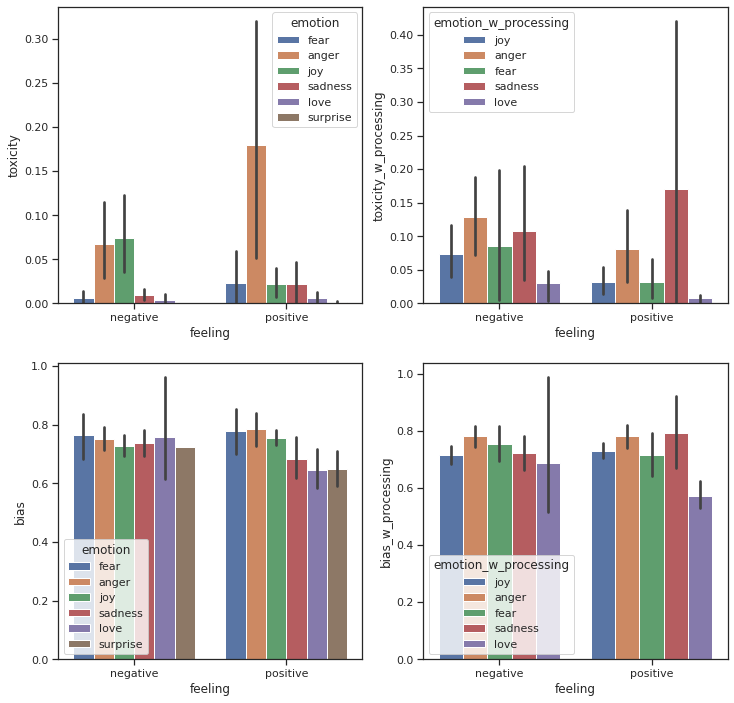

In [26]:
def plot_bias_tox_emotion_alt():
    def plot(**kwargs):
        kwargs.setdefault("hue", "emotion")
        sns.barplot(data=df, x='feeling_str', order=_feelings_order, **kwargs).set(xlabel = "feeling")
    fig, axes = plt.subplots(2, 2, figsize=(12,12))
    plot(ax=axes[0, 0], y='toxicity')
    plot(ax=axes[0, 1], y='toxicity_w_processing', hue='emotion_w_processing')
    plot(ax=axes[1, 0], y='bias')
    plot(ax=axes[1, 1], y='bias_w_processing', hue='emotion_w_processing')
    plt.show()

plot_bias_tox_emotion_alt()

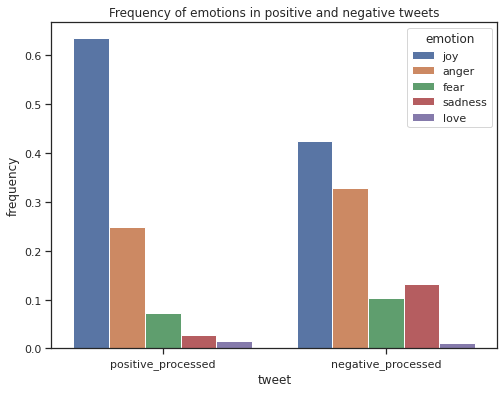

In [27]:
def plot_emotion_freq():
    df_freq = df_emotion_freq.reset_index().melt(id_vars='index', var_name='tweet', value_name='frequency')
    df_freq = df_freq.rename(columns={df_freq["index"].name: 'emotion'})
    plt.figure(figsize=(8,6))
    sns.barplot(data=df_freq, x='tweet', y='frequency', hue='emotion').set(title="Frequency of emotions in positive and negative tweets")
    plt.show()

plot_emotion_freq()

## Positivity/Bias Evaluation 

We install and import a sentiment analysis model that measures positivity as a value from 0 to 1 (instead of being a binary feeling - positive or negative - in the fashion that our dataset is labeled). This will allow us to compare positivity for similar tweets further down in our project.

In [28]:
!pip install pysentimiento

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 KB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=33a77570596601d635763397aadbdd0dee6ee49a4c46d769ffd249011d5e9e65
  Stored in directory: /root/.cache/pip/wheels/5e/8c/80/c3646df8201ba6f5070297fe3779a4b70265d0bfd961c15302
Successfully built emoji


In [29]:
from pysentimiento import create_analyzer

In [30]:
analyzer = create_analyzer(task="sentiment", lang="en")

Downloading:   0%|          | 0.00/890 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/540M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [31]:
print(analyzer.predict(positive_tweets[0]).probas["POS"])

0.00864405557513237


We plot bias and positivity to see if we're able to find any trends.

In [32]:
# no processing
positivity = []
for tweet in positive_tweets + negative_tweets:
  positivity.append(analyzer.predict(tweet).probas["POS"])

df["positivity"] = positivity

# with processing
positivity_p = []
for tweet in pos_tweets_processed + neg_tweets_processed:
  positivity_p.append(analyzer.predict(tweet).probas["POS"])

df["positivity_w_processing"] = positivity_p


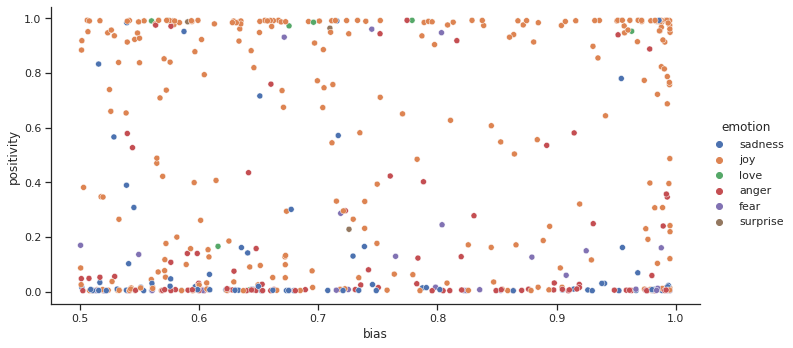

In [33]:
sns.relplot(data=df, x='bias', y='positivity', hue='emotion', hue_order=_emotions, aspect=2)
plt.show()

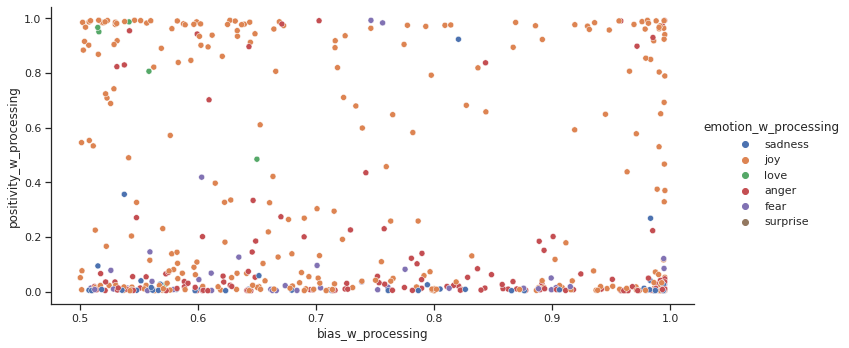

In [34]:
sns.relplot(data=df, x='bias_w_processing', y='positivity_w_processing', hue='emotion_w_processing', hue_order=_emotions, aspect=2)
plt.show()

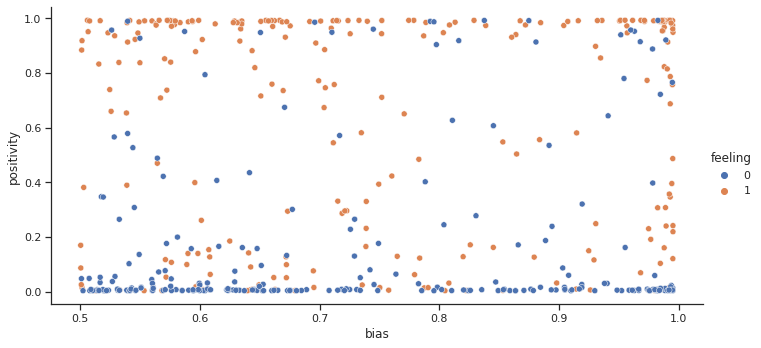

In [35]:
sns.relplot(data=df, x='bias', y='positivity', hue='feeling', aspect=2)
plt.show()

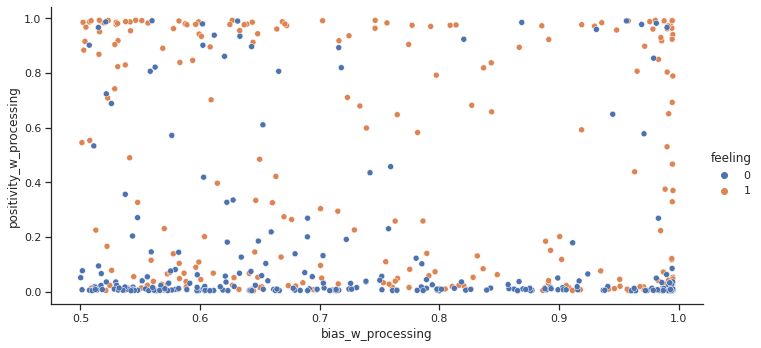

In [36]:
sns.relplot(data=df, x='bias_w_processing', y='positivity_w_processing', hue='feeling', aspect=2)
plt.show()

## Find Overrepresented Words

Finding overrepresented words is a typical content analysis task. Here we retrieve them and create word clouds for easier visualization.

In [37]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [38]:
pos_string = ' '.join(positive_tweets)
neg_string = ' '.join(negative_tweets)

In [39]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
 
stop_words = set(stopwords.words('english'))
 
pos_tokens = tokenizer.tokenize(pos_string)
# converts the words in word_tokens to lower case and then checks whether
#they are present in stop_words or not
pos_filtered_sentence = []
 
for w in pos_tokens:
    if w not in stop_words:
        pos_filtered_sentence.append(w)
 
print(pos_tokens)
print(pos_filtered_sentence)

neg_tokens = tokenizer.tokenize(neg_string)
# converts the words in word_tokens to lower case and then checks whether
#they are present in stop_words or not
neg_filtered_sentence = []
 
for w in neg_tokens:
    if w not in stop_words:
        neg_filtered_sentence.append(w)
 
print(neg_tokens)
print(neg_filtered_sentence)



['bradleyjp', 'decidedly', 'undecided', 'Depends', 'on', 'the', 'situation', 'When', 'I', 'm', 'out', 'with', 'the', 'people', 'I', 'll', 'be', 'in', 'Chicago', 'with', 'Maybe', 'Mountgrace', 'lol', 'i', 'know', 'its', 'so', 'frustrating', 'isnt', 'it', 'kathystover', 'Didn', 't', 'go', 'much', 'of', 'any', 'where', 'Life', 'took', 'over', 'for', 'a', 'while', 'TashaWilson', 'like', 'questions', 'she', 'asks', 'me', 'the', 'date', 'etc', 'i', 'say', 'that', 'i', 'have', 'been', 'to', 'birmingham', 'lol', 'its', 'weird', 'o', 'well', 'u', 'ok', 'SusanCosmos', 'speakgirl', 'Thx', '4', 'sharing', 'About', 'to', 'go', 'to', 'bed', 'Sleeping', 'really', 'late', 'tomorrow', 'I', 'am', 'so', 'glad', 'the', 'Tigers', 'won', 'tonight', 'AHH', 'i', 'm', 'so', 'HAPPY', 'I', 'just', 'found', 'my', 'ipod', 'God', 'is', 'sooo', 'good', 'to', 'me', 'poepiandzegiant', 'oops', 'just', 'saw', 'you', 'said', 'hello', 'Hi', 'there', 'jayadore', 'fuckyeah', 'also', 'yay', 'shoes', 'and', 'bag', 'I', 'm', '

In [40]:
from collections import Counter
# Pass the split_it list to instance of Counter class.
pos_counter = Counter(pos_filtered_sentence)
neg_counter = Counter(neg_filtered_sentence)
  
# most_common() produces k frequently encountered
# input values and their respective counts.
pos_most_occur = pos_counter.most_common(10)
neg_most_occur = neg_counter.most_common(10)
  
print(pos_most_occur)
print(neg_most_occur)

[('I', 67), ('http', 20), ('good', 18), ('day', 16), ('quot', 16), ('fun', 14), ('lol', 13), ('go', 13), ('time', 13), ('love', 13)]
[('I', 125), ('day', 16), ('miss', 16), ('im', 14), ('last', 12), ('get', 12), ('go', 11), ('work', 10), ('today', 9), ('2', 9)]


In [41]:
pos_without_pre = ' '.join(df[df["feeling"]==1]["corpus"])
neg_without_pre = ' '.join(df[df["feeling"]==0]["corpus"])
pos_pre = ' '.join(df[df["feeling"]==1]["corpus_w_processing"])
neg_pre = ' '.join(df[df["feeling"]==0]["corpus_w_processing"])

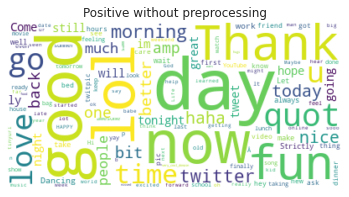

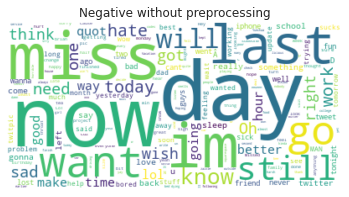

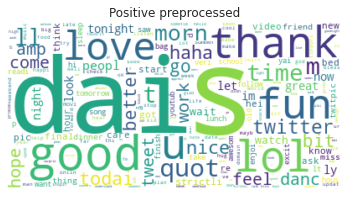

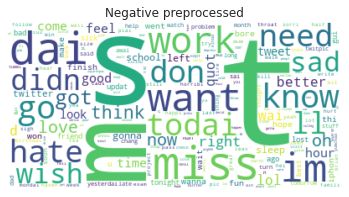

In [42]:
#Positive twits without preprocessing
pos_word_cloud = WordCloud(collocations = False, background_color = 'white').generate(pos_without_pre)
plt.title("Positive without preprocessing")
plt.imshow(pos_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Negative twits without preprocessing
neg_word_cloud = WordCloud(collocations = False, background_color = 'white').generate(neg_without_pre)
plt.title("Negative without preprocessing")
plt.imshow(neg_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#Positive twits preprocessed
pos_word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(pos_pre)
plt.title("Positive preprocessed")
plt.imshow(pos_word_cloud2, interpolation='bilinear')
plt.axis("off")
plt.show()


#Negative twits preprocessed
neg_word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(neg_pre)
plt.title("Negative preprocessed")
plt.imshow(neg_word_cloud2, interpolation='bilinear')
plt.axis("off")
plt.show()


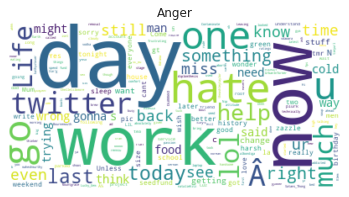

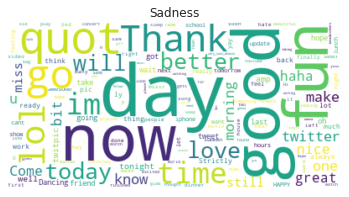

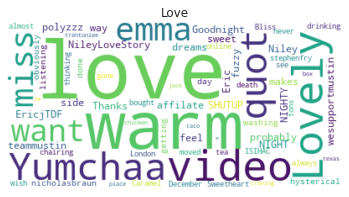

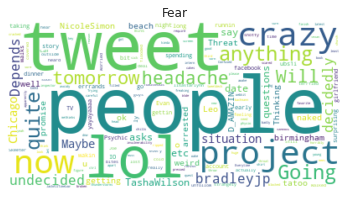

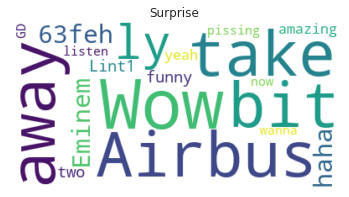

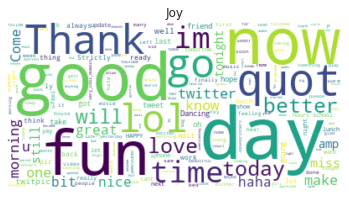

In [43]:
#Preprocessed corpus makes ugly clouds, so for emotions we will use the starting corpus
anger_without_pre = ' '.join(df[df["emotion"]=="anger"]["corpus"])
sadness_without_pre = ' '.join(df[df["emotion"]=="sadness"]["corpus"])
joy_without_pre = ' '.join(df[df["emotion"]=="joy"]["corpus"])
love_without_pre = ' '.join(df[df["emotion"]=="love"]["corpus"])
fear_without_pre = ' '.join(df[df["emotion"]=="fear"]["corpus"])
surprise_without_pre = ' '.join(df[df["emotion"]=="surprise"]["corpus"])

anger_wc = WordCloud(collocations = False, background_color = 'white').generate(anger_without_pre)
plt.title("Anger")
plt.imshow(anger_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

joy_wc = WordCloud(collocations = False, background_color = 'white').generate(joy_without_pre)
plt.title("Sadness")
plt.imshow(joy_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

love_wc = WordCloud(collocations = False, background_color = 'white').generate(love_without_pre)
plt.title("Love")
plt.imshow(love_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

fear_wc = WordCloud(collocations = False, background_color = 'white').generate(fear_without_pre)
plt.title("Fear")
plt.imshow(fear_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

surprise_wc = WordCloud(collocations = False, background_color = 'white').generate(surprise_without_pre)
plt.title("Surprise")
plt.imshow(surprise_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

joy_wc = WordCloud(collocations = False, background_color = 'white').generate(joy_without_pre)
plt.title("Joy")
plt.imshow(joy_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Similarity Measures

**Note:** not recommended to run on a large number of tweets (>250)

We split each tweet into words, for correct input of the gensim Word2Vec model.

In [44]:
print(pos_tweets_processed)
splitted_sentences = []
for tweet in pos_tweets_processed + neg_tweets_processed:
  sentence = []
  for word in tweet.split():
    sentence.append(word)

  splitted_sentences.append(sentence)

print(splitted_sentences)

['bradleyjp decidedli undecid depend situat when i m peopl i ll chicago with mayb', 'mountgrac lol know frustrat isnt it', 'kathystov didn t life took', 'tashawilson like question ask date etc i birmingham lol weird o u ok', 'susancosmo speakgirl thx 4 share', 'about bed sleep late tomorrow i glad tiger won tonight', 'ahh i m happi i ipod god sooo good me', 'poepiandzegi oop saw said hello hi', 'jayador fuckyeah yai shoe bag i m excit', 'twitter us remind peopl forgot ask given dai it excel inspir', 'kirsti gilfo yup that s mmm yum cha have lot dumpl', 'mum s bed nip tuck time noow', 'wkjthd but i know he awesom plan all and i hold head high bless all how ar you', 'have lol big time apprentic video http ping fm vxpnd via tdruri thank rebel aceman laugh too', 'sometim peopl hate twitter amus peopl us twitter', '60 beauti logo design tutori and resourc http bit ly q5jo0 wel nice', 'junderst ll ain t truth', 'nileylovestori probabl wesupportmustin i don t affil nilei video teammustin', 'm

In [45]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

We import and train the model. The word embeddings (size 100, gensim default) are stored in the 'result' variable.

<ipython-input-46-8e16d11ed1fe>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]


Vocab len:  1996


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 132 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 132 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


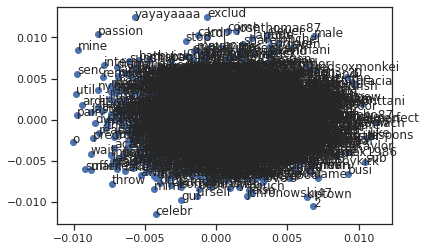

In [46]:
# following tutorial from https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

# instancing the model and applying PCA
model = Word2Vec(splitted_sentences, min_count=1)
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)


pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
print("Vocab len: ", len(words) )
for i, word in enumerate(words):
 pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

We store the embeddings in an easier to use dictionary.

In [47]:
embedding_size = 100 # gensim default

word2vec = {}
for i, word in enumerate(words):
  word2vec[word] = X[i]

Calculate document embeddings for each tweet and store them in a simple list.

In [48]:
doc2vec = []
for tweet in splitted_sentences:
  tweet_vec = [0] * embedding_size # vector of this doc in particular in init with zeros for iterative summation
  for i in range(embedding_size):
    value_at_j = 0
    for word in tweet:
      value_at_j += word2vec[word][i]
    tweet_vec[i] = value_at_j
  tweet_vec = [x/len(tweet) for x in tweet_vec] # divide each element by total num of word vectors
  doc2vec.append(tweet_vec)

print(doc2vec[0])

  

[-0.001694658091374939, -0.0010550303517707757, 0.00031653208498028107, -0.00030646007508039474, 0.0009355504818293932, 0.00010987145443713027, -0.0015071573226513074, -0.000538254377586002, -0.0004946808995945114, -0.0006034256319773183, 0.0001846211453084834, -0.0009314563358202577, 0.001259222481166944, -0.00022570370388815979, 0.0008180873826079603, 0.0009642216048502762, 0.0004014758287667064, -0.0010275417506428702, 0.0016975286832478429, -0.001192052162098532, -0.0005784028949814715, 0.0009796886016764411, 0.0002976820687763393, -0.0016418545440371548, -0.0010872326794404735, -0.0007508513008360751, 0.001206699850237263, -0.00019716653624917463, 0.00025484487248052446, 0.0009753238409757614, 6.945935196459427e-05, 0.002461941296392719, -0.0004037476859853736, 0.0009263359313860876, 0.0006830812726548174, 0.00010395362499236529, -0.0018897737073919935, 0.0003307599238593996, -0.000770788415788307, 0.0006629167941615119, 0.001240329943487138, 0.0009323429247680386, -0.000705188377

Define cosine similarity.

In [49]:
from operator import itemgetter
import numpy as np
def cosine_similarity(p1, p2):
    # Cosine similarity is the dot product of normalized vectors
    return np.dot(p1, p2)/(np.linalg.norm(p1) * np.linalg.norm(p2))

Get random positive tweet, calculate similarities, and retrieve most similar tweets.

In [50]:
n = random.randint(0, n_tweets-1)

similarities = {}
for i, tweet in enumerate(pos_tweets_processed + neg_tweets_processed):
    if i == n:
      continue
    p1 = np.array(doc2vec[i])
    p2 = np.array(doc2vec[n])
    similarities[i] = cosine_similarity(p1, p2)

    
# retrieve
res = dict(sorted(similarities.items(), key = itemgetter(1), reverse = True)[:10])
print(res)

print("Random tweet: ", (positive_tweets + negative_tweets)[n])
print("Positivity: ", df.loc[n]["positivity_w_processing"])
print("Emotion: ", df.loc[n]["emotion"])
print("++++++")

d = {'similarity': [1], 'positivity': [df.loc[n]["positivity_w_processing"]], 'og_or_not': [1]}
pos_positivity = []

for key in res:
  print((positive_tweets + negative_tweets)[key])
  print("Similar Tweet", (positive_tweets + negative_tweets)[key])
  print("Feeling: ", df.loc[key]["feeling"])
  print("Emotion: ", df.loc[key]["emotion"])
  print("++++++")
  d["similarity"].append(res[key])
  d["positivity"].append(df.loc[key]["positivity_w_processing"])
  pos_positivity.append(df.loc[key]["positivity_w_processing"])
  d["og_or_not"].append(0)

pos_df = pd.DataFrame(data=d)
print(pos_df.head())


{307: 0.3523813180491799, 152: 0.2771001883892776, 375: 0.2630132246807353, 96: 0.2585384877698169, 187: 0.2548472839159807, 447: 0.24820796074705415, 430: 0.2467860912550467, 72: 0.23940623695388627, 15: 0.2390341284072937, 93: 0.23533643935552315}
Random tweet:  designing my page
Positivity:  0.032047636806964874
Emotion:  joy
++++++
Im O.deee tired and jus finished my codes for web design II blahh school suckss
Similar Tweet Im O.deee tired and jus finished my codes for web design II blahh school suckss
Feeling:  0
Emotion:  sadness
++++++
Had an totally awesome session at Tempe Town Lake!!! Can't wait to share Dianna &amp; Alex's pics!
Similar Tweet Had an totally awesome session at Tempe Town Lake!!! Can't wait to share Dianna &amp; Alex's pics!
Feeling:  1
Emotion:  joy
++++++
hateeee history of rock!
Similar Tweet hateeee history of rock!
Feeling:  0
Emotion:  anger
++++++
these instructions are from stinksville. at the end of day one it's rovio: 1 jerry: 0. stay tuned.... pagin

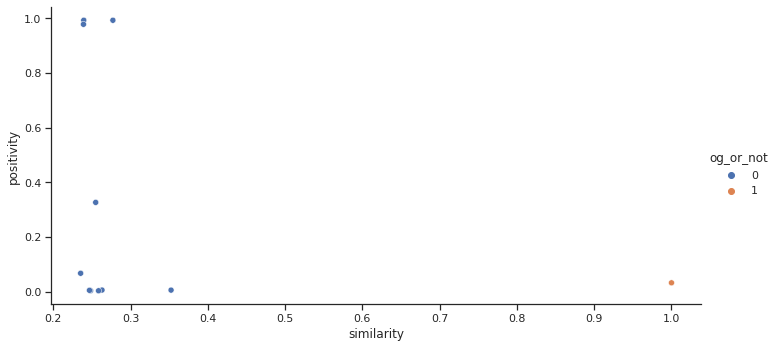

In [51]:
sns.relplot(data=pos_df, x='similarity', y='positivity', hue='og_or_not', aspect=2)
plt.show()

In [52]:
print("Positivity of Query Tweet (labeled as positive): ", df.loc[n]["positivity_w_processing"])
print("Average Positivity of Similar Tweets: ", sum(pos_positivity) / len(pos_positivity))

Positivity of Query Tweet (labeled as positive):  0.032047636806964874
Average Positivity of Similar Tweets:  0.33768269037827847


Do the same, but for a random negative tweet.

In [53]:
n = random.randint(n_tweets, 2*n_tweets-1)

similarities = {}
for i, tweet in enumerate(pos_tweets_processed + neg_tweets_processed):
    if i == n:
      continue
    p1 = np.array(doc2vec[i])
    p2 = np.array(doc2vec[n])
    similarities[i] = cosine_similarity(p1, p2)

    
# retrieve
res = dict(sorted(similarities.items(), key = itemgetter(1), reverse = True)[:10])
print(res)

print("Random tweet: ", (positive_tweets + negative_tweets)[n])
print("Emotion: ", df.loc[n]["emotion"])
print("++++++")

neg_d = {'similarity': [1], 'positivity': [df.loc[n]["positivity_w_processing"]], 'og_or_not': [1]}
neg_positivity = []
for key in res:
  print("Similar Tweet", (positive_tweets + negative_tweets)[key])
  print("Feeling: ", df.loc[key]["feeling"])
  print("Emotion: ", df.loc[key]["emotion"])
  print("++++++")
  neg_d["similarity"].append(res[key])
  neg_d["positivity"].append(df.loc[key]["positivity_w_processing"])
  neg_positivity.append(df.loc[key]["positivity_w_processing"])
  neg_d["og_or_not"].append(0)

neg_df = pd.DataFrame(data=d)

{464: 0.7283520854325973, 356: 0.6963687057593276, 252: 0.6879557961485696, 201: 0.6541357669100917, 296: 0.6372733405569928, 132: 0.6302754252980332, 6: 0.6253620941294994, 446: 0.6123823909329349, 277: 0.6098468281530306, 428: 0.6086827676902653}
Random tweet:  @Chicago_Ted I just miss driving my car.  I haven't driven it since I got back yet.
Emotion:  sadness
++++++
Similar Tweet @22lrhunter I'm  because I haven't seen it yet. I read a lot of mixed reviews for the movie but everyone I know who'sseenitthinksitsgreat!
Feeling:  0
Emotion:  joy
++++++
Similar Tweet I'm sad because I know if I were a celebrity chef, I would be Paula Deen. I love butter!
Feeling:  0
Emotion:  sadness
++++++
Similar Tweet @lisastarlynn I haven't heard anything. I'll tweet you as soon as I hear. I'm really worried actually
Feeling:  0
Emotion:  fear
++++++
Similar Tweet I had sooo much fun :] ..xxLenaxo I missed u there! =*  @EmilyyPettyy we have to do this again! :p ;] going to have a meal now *yay*
Feel

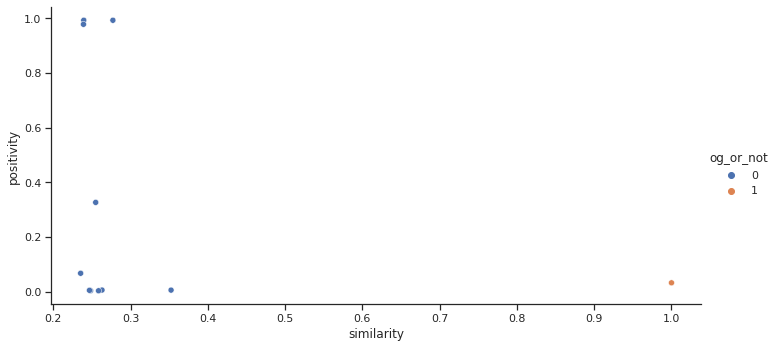

In [54]:
sns.relplot(data=neg_df, x='similarity', y='positivity', hue='og_or_not', aspect=2)
plt.show()

In [55]:
print("Positivity of Query Tweet (labeled as negative): ", df.loc[n]["positivity_w_processing"])
print("Average Positivity of Similar Tweets: ", sum(neg_positivity) / len(neg_positivity))

Positivity of Query Tweet (labeled as negative):  0.008522210642695427
Average Positivity of Similar Tweets:  0.45245439107529817
